In [36]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask

In [37]:
set_plotting_style()

In [38]:
try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

In [48]:
def make_df(fname):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/BS_(x|y)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError)$/",
                     "run","luminosityBlock",
                    ],outputtype=dict,namedecode="ascii")
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
        & (arrs["DV_rho"]>1.0).any()
    )

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv)
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    # skim more
    df = df.query("(cosphi > 0.) and (Muon1_charge != Muon2_charge)")
    return df
    
df_data = pd.concat(
    map(make_df,glob.glob(
        "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_vtestskim1cm/*.root"
    ))
).reset_index(drop=True)
df_mc = make_df("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau50mm.root").reset_index(drop=True)

In [49]:
if True:
# if False:
    df_data.to_pickle("data/df_data.pkl")
    df_mc.to_pickle("data/df_mc.pkl")

In [50]:
df_mc.head()

,nDV,nPV,nPVM,nMuon,nGenPart,nGenMuon,pass_skim,pass_l1,pass_fiducialgen,MET_pt,...,absdphimumu,cosphi,DV_redchi2,DV_xyErrorMax,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt,maxdxy,mindxy
0,1,11,2,2,9,2,True,True,True,36.795246,...,0.547543,1.000000,0.438167,0.005694,1.066454,1.358333,0.016510,0.020892,1.349426,-0.186607
1,1,12,2,2,17,4,True,True,True,38.700554,...,2.627011,0.999700,0.000847,0.002386,1.224413,0.528511,0.013034,0.010552,0.848242,-1.117955
2,1,14,1,2,11,2,True,True,True,36.773937,...,0.874017,0.999971,0.000963,0.001972,1.040387,0.464748,0.015950,0.015825,4.317966,-2.775682
3,1,16,8,2,10,2,True,True,True,3.516805,...,0.729407,0.999959,0.609632,0.002097,0.899231,0.928609,0.012259,0.010641,2.645410,-1.110090
4,1,8,1,2,11,2,True,True,True,3.666943,...,1.026330,0.999997,0.484172,0.002047,0.792309,0.441621,0.013987,0.010255,4.872239,-5.296400


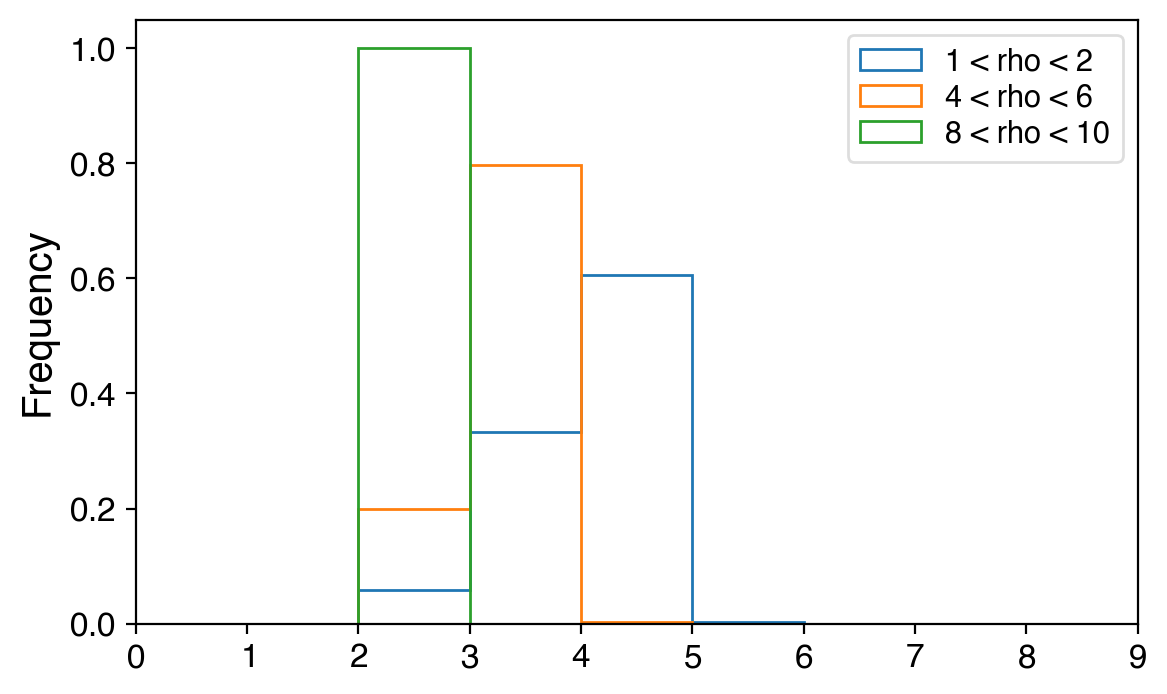

In [51]:
df = df_mc

fig, ax = plt.subplots()
for low,high in [
    [1,2],
    [4,6],
    [8,10],
]:
    df.query(
        "(@low < DV_rho < @high)"
        " and abs(Muon1_eta)<0.1"
        " and abs(Muon1_vz)<5"
        " and cosphi>0.95"
        " and not DV_inPixelRectangles"
            )["Muon1_nValidPixelHits"].plot.hist(
        ax=ax,
        bins=np.arange(10),
        histtype="step",
        label=f"{low} < rho < {high}",
        density=True,
    )
ax.legend()

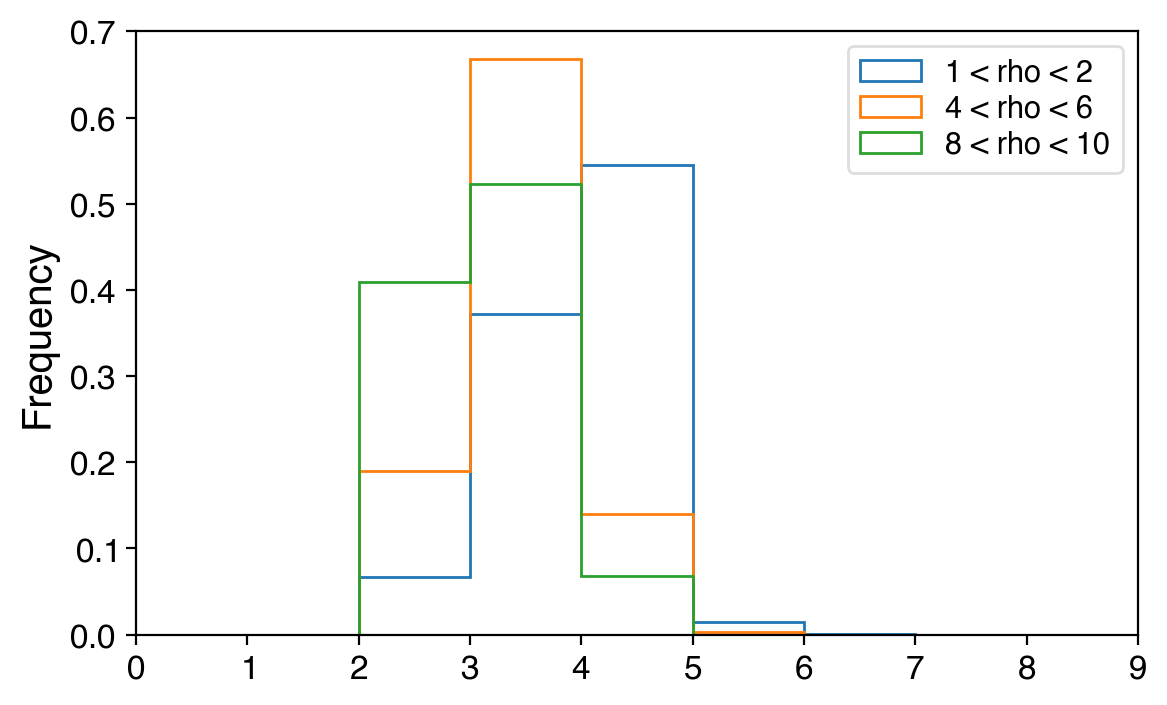

In [52]:
df = df_data

fig, ax = plt.subplots()
for low,high in [
    [1,2],
    [4,6],
    [8,10],
]:
    df.query(
        "(@low < DV_rho < @high)"
        " and abs(Muon1_eta)<0.6"
        " and abs(Muon1_vz)<15"
        " and cosphi>0.95"
        " and Muon1_pt>25"
        " and not DV_inPixelRectangles"
            )["Muon1_nValidPixelHits"].plot.hist(
        ax=ax,
        bins=np.arange(10),
        histtype="step",
        label=f"{low} < rho < {high}",
        density=True,
    )
ax.legend()

In [53]:
df.columns

Index(['nDV', 'nPV', 'nPVM', 'nMuon', 'nGenPart', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_fiducialgen', 'MET_pt', 'MET_phi', 'BS_x', 'BS_y',
       'Muon1_pt', 'Muon2_pt', 'Muon1_eta', 'Muon2_eta', 'Muon1_phi',
       'Muon2_phi', 'Muon1_m', 'Muon2_m', 'Muon1_trackIso', 'Muon2_trackIso',
       'Muon1_chi2', 'Muon2_chi2', 'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge',
       'Muon2_charge', 'Muon1_dxy', 'Muon2_dxy', 'Muon1_nValidMuonHits',
       'Muon2_nValidMuonHits', 'Muon1_nValidPixelHits',
       'Muon2_nValidPixelHits', 'Muon1_nMatchedStations',
       'Muon2_nMatchedStations', 'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_trk_qoverp', 'Muon2_trk_qoverp',
       'Muon1_dxyError', 'Muon2_dxyError', 'Muon1_trk_qoverpError',
       'Muon2_trk_qoverpError', 'Muon1_vx', 'Muon2_vx', 'Muon1_vy', 'Muon2_vy',
       'Muon1_vz', 'Muon2_vz', 'Muon1_dxyCorr', 'Muon2_dxyCorr', 'DV_x',


In [78]:
plotdir = "plots_split_v2/"
os.system("mkdir -p {}".format(plotdir))

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    ["near pix.",lambda df:  df["DV_inPixelRectangles"]],
    ["away pix.",lambda df: ~df["DV_inPixelRectangles"]],
],split_label = "splitpixel"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"dimuon $p_T$<20",lambda df: (df["dimuon_pt"]<20)],
    [r"20<dimuon $p_T$<50",lambda df:  (df["dimuon_pt"]<50) & (df["dimuon_pt"]>20)],
    [r"dimuon $p_T$>50",lambda df:  (df["dimuon_pt"]>50)],
],split_label = "splitpt"))

selinfos.append(dict(vsels=[
    [r"1.0<DV $\rho$<3.6",lambda df:  (np.abs(df["DV_rhoCorr"])<3.6) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"3.6<DV $\rho$<7.3",lambda df:  (np.abs(df["DV_rhoCorr"])<7.3) & (np.abs(df["DV_rhoCorr"])>3.6)],
    [r"7.3<DV $\rho$<11.5",lambda df:  (np.abs(df["DV_rhoCorr"])<11.5) & (np.abs(df["DV_rhoCorr"])>7.3)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["mass<5",lambda df:  (df["dimuon_mass"]<5)],
    ["5<mass<10",lambda df:  (df["dimuon_mass"]<10) & (df["dimuon_mass"]>5)],
    ["mass>10",lambda df:  (df["dimuon_mass"]>10)],
],split_label = "splitmass"))

plots = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(5)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(100)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,100), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,100), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,100), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["maxdxy"]], np.linspace(-6,6,150), dict(title="max(Muon1 dxy, Muon2 dxy)",logy=True,shortname="maxdxy")],
    [[lambda df: df["mindxy"]], np.linspace(-6,6,150), dict(title="min(Muon1 dxy, Muon2 dxy)",logy=True,shortname="mindxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df["Muon1_redchi2"],lambda df: df["Muon2_redchi2"]], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_adqpt"],lambda df: df["Muon2_adqpt"]], np.linspace(0,0.05,100), dict(title="Muon abs(qoverpError/qoverp)",shortname="relqoverp")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,5,100), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="Is in pixel rectangle?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,200), dict(title="DV rho",logy=True,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,1.5,100), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.1,100), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(0.2,50,300), dict(title="Dimuon mass",logy=True,logx=True,shortname="mass")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.2,100), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    
]

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plots:
        fig,ax = plt.subplots()

        ymax = 0.
        for df,label,linestyle in [
            [df_mc,"mc","--"],
            [df_data,"data","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "mc") and (("mass<5" in sel_label) or ("mass<10" in sel_label)): continue
                
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs]).normalize()
                h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
#     break
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=150)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

plots_split_v2//splitnone_nValidPixelHits.png
plots_split_v2//splitnone_nTrackerLayers.png
plots_split_v2//splitnone_nMatchedStations.png
plots_split_v2//splitnone_nValidMuonHits.png
plots_split_v2//splitnone_eta.png
plots_split_v2//splitnone_phi.png
plots_split_v2//splitnone_pt.png
plots_split_v2//splitnone_absdxy.png
plots_split_v2//splitnone_signeddxy.png
plots_split_v2//splitnone_maxdxy.png
plots_split_v2//splitnone_mindxy.png
plots_split_v2//splitnone_dxyError.png
plots_split_v2//splitnone_Muonchi2.png
plots_split_v2//splitnone_relqoverp.png
plots_split_v2//splitnone_trackIso.png
plots_split_v2//splitnone_inPixel.png
plots_split_v2//splitnone_rho.png
plots_split_v2//splitnone_dphimumu.png
plots_split_v2//splitnone_dphimudv.png
plots_split_v2//splitnone_mass.png
plots_split_v2//splitnone_dimuonpt.png
plots_split_v2//splitnone_xyErrorMax.png
plots_split_v2//splitnone_DVchi2.png
plots_split_v2//splitnone_nPV.png
plots_split_v2//splitnone_nPVM.png
plots_split_v2//splitpixel_nValidPixe

In [76]:
# Hist2D(df_data[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)
# Hist2D(df_mc[["DV_x","DV_y"]].values,bins=np.linspace(-12,12,100)) #.plot(logz=True)

In [80]:
with open("plots_split_v2/description.txt","w") as fh:
    fh.write("""
Selection: ==2 OS muons, ==1 DV, DV rho > 1cm, cos(dphi(dimuon,DV))>0 <br>
Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>near or away from pixel material ("splitpixel_")</li>
<li>DV rho ("splitrho_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>pT of dimuon system ("splitpt_")</li>
<li>mass of dimuon system ("splitmass_")</li>
</ul>
    """)
!niceplots plots_split_v2

Not converting anything
ln: creating symbolic link `plots_split_v2/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_split_v2/
